In [1]:
! pip install mysql-connector-python
from sqlalchemy import create_engine
import pandas as pd

user = "root"
# password = "password" 
host = "localhost"
database = "Project_2" 

# Create the engine
engine = create_engine(f"mysql+mysqlconnector://{user}:@{host}/{database}")

In [2]:
# Test connection by listing tables
pd.read_sql("SHOW TABLES", engine)

,Tables_in_project_2
0,customer_engagement
1,customer_journey
2,customers
3,geography
4,products
5,reviews


In [3]:
# SQL query
query = "SELECT ReviewID, CustomerID, ProductID, ReviewDate, Rating, ReviewText, CAST(ReviewDate AS DATE) AS DATE FROM reviews"

# read and save as DataFrame
df = pd.read_sql(query, engine)
df.head()

,ReviewID,CustomerID,ProductID,ReviewDate,Rating,ReviewText,DATE
0,1,795,630,2025-10-16,3,Customer support was very helpful.,2025-10-16
1,2,439,769,2024-07-18,4,Shipping was fast and the item was well-packaged.,2024-07-18
2,3,181,697,2024-05-05,1,I had a bad experience with this product.,2024-05-05
3,4,987,338,2023-01-06,1,Not worth the money.,2023-01-06
4,5,972,25,2024-10-04,3,Not worth the money.,2024-10-04


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
df.shape

(700, 7)

## Quick EDA

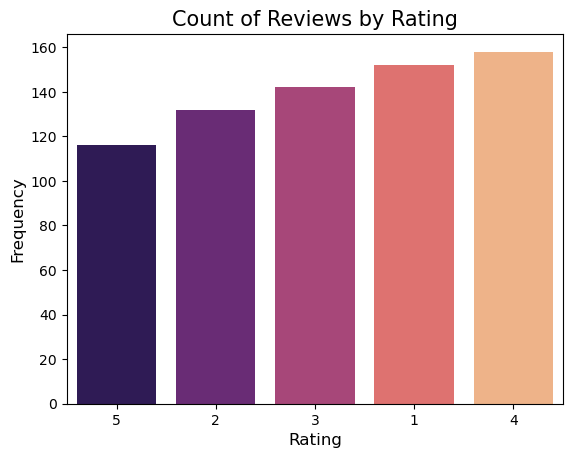

In [6]:
# sort records by ratings count
rating_counts = df["Rating"].value_counts().sort_values()

# Plot count of reviews by rating
sns.countplot(data=df, x="Rating", palette="magma", order=rating_counts.index)
plt.title("Count of Reviews by Rating", fontsize=15)
plt.xlabel("Rating", fontsize=12,)
plt.ylabel("Frequency", fontsize=12)
plt.show()

## Sentiment Analysis

In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
# instantiate the sentiment analyser
sia = SentimentIntensityAnalyzer() 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/olawale/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
sia.polarity_scores(df["ReviewText"][0])

{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'compound': 0.6997}

In [9]:
# function to calculate sentiment scores 

def evaluate_sentiment(ReviewText):
    sentiment = sia.polarity_scores(ReviewText)    # store sentiment scores for the review text
    return sentiment["compound"]          # get compound score, between -1 (most negative) and 1 (most positive)

In [10]:
# Apply sentiment analysis to calculate sentiment scores for each review
df["SentimentScore"] = df["ReviewText"].apply(evaluate_sentiment)
df.head()

,ReviewID,CustomerID,ProductID,ReviewDate,Rating,ReviewText,DATE,SentimentScore
0,1,795,630,2025-10-16,3,Customer support was very helpful.,2025-10-16,0.6997
1,2,439,769,2024-07-18,4,Shipping was fast and the item was well-packaged.,2024-07-18,0.0000
2,3,181,697,2024-05-05,1,I had a bad experience with this product.,2024-05-05,-0.5423
3,4,987,338,2023-01-06,1,Not worth the money.,2023-01-06,-0.1695
4,5,972,25,2024-10-04,3,Not worth the money.,2024-10-04,-0.1695


In [11]:
#  function to categorise sentiment using both the sentiment score and the review rating
def categorise_sentiment(SentimentScore, Rating):
    
    # Use both the text sentiment score and the numerical rating to determine sentiment category
    if SentimentScore >= 0.5:  # Strong positive sentiment
        if Rating >= 4:
            return "Highly Positive"
        elif Rating == 3:
            return "Positive"
        else:  # Low rating but positive sentiment
            return "Mixed"

    elif SentimentScore <= -0.1:  # Strong negative sentiment
        if Rating <= 2:
            return "Highly Negative"
        elif Rating == 3:
            return "Negative"
        else:  # High rating but negative sentiment
            return "Mixed"

    else:  # Neutral sentiment (-0.0 to 0.49)
        if Rating >= 4:
            return "Positive"
        elif Rating <= 2:
            return "Negative"
        else:
            return "Neutral"


In [12]:
df['SentimentCategory'] = df.apply(
    lambda row: categorise_sentiment(row["SentimentScore"], row["Rating"]), axis=1)
df

,ReviewID,CustomerID,ProductID,ReviewDate,Rating,ReviewText,DATE,SentimentScore,SentimentCategory
0,1,795,630,2025-10-16,3,Customer support was very helpful.,2025-10-16,0.6997,Positive
1,2,439,769,2024-07-18,4,Shipping was fast and the item was well-packaged.,2024-07-18,0.0000,Positive
2,3,181,697,2024-05-05,1,I had a bad experience with this product.,2024-05-05,-0.5423,Highly Negative
3,4,987,338,2023-01-06,1,Not worth the money.,2023-01-06,-0.1695,Highly Negative
4,5,972,25,2024-10-04,3,Not worth the money.,2024-10-04,-0.1695,Negative
...,...,...,...,...,...,...,...,...,...
695,696,277,959,2025-02-22,2,Not worth the money.,2025-02-22,-0.1695,Highly Negative
696,697,607,716,2024-10-26,4,Amazing value for the price.,2024-10-26,0.7351,Highly Positive
697,698,616,725,2024-08-12,3,"Excellent product, highly recommend!",2024-08-12,0.7773,Positive
698,699,348,305,2025-07-25,3,The quality is top-notch.,2025-07-25,0.0000,Neutral


In [13]:
# Save the DataFrame to a new CSV file
df.to_csv("customer_reviews_sentiment.csv", index=False)